In [116]:
from utils import extract_triplets
from src.wiki_utils import wiki_scrape
from src.graph_utils import draw_kg, filter_graph

In [84]:
wiki_data = wiki_scrape('Высшая школа экономики')

Links Scraped: 100%|███████████████████████████████████████████████████████████████████| 378/378 [00:31<00:00, 11.95/s]

Wikipedia pages scraped: 176


In [86]:
wiki_data = wiki_data[wiki_data.text.notnull() & 
                      ~wiki_data.link.str.contains("Category|Категория")
                     ].drop_duplicates(subset='text')

In [31]:
from transformers import pipeline, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('/data/artem/rebel/model/rebel-ru', truncation=True)
triplet_extractor = pipeline('text2text-generation', model='/data/artem/rebel/model/rebel-ru',
                             tokenizer=tokenizer)

In [87]:
text_to_feed_ = wiki_data.text.to_list()[0].replace('\n\n','\n').split('\n')
text_to_feed = []
for text in text_to_feed_:
    if len(text) > 1024:
        text = text[:1024]
    text_to_feed.append(text)

In [90]:
text_to_feed = text_to_feed[0] ### taking first paragraph with general information
text_to_feed

'Национальный исследовательский университет «Высшая школа экономики» (НИУ ВШЭ; "Вы́шка") — автономное учреждение, федеральное государственное высшее учебное заведение. ВШЭ создана в 1992 году, нынешний статус носит с 2009 года. Основной кампус находится в Москве, ещё три — в Санкт-Петербурге, Нижнем Новгороде и Перми.'

In [118]:
extracted_texts = []
for sample_feed in [text_to_feed]: 
    # We need to use the tokenizer manually since we need special tokens.
    extracted_texts.append(triplet_extractor.tokenizer.batch_decode([triplet_extractor(
        sample_feed, return_tensors=True, return_text=False)[0]["generated_token_ids"]])
      )
# Function to parse the generated text and extract the triplets
extracted_triplets = []
for extracted_text in extracted_texts:
    extracted_triplets.append(extract_triplets(extracted_text[0]))

In [75]:
subjects = []
objects = []
relations = []
for triplets in extracted_triplets:
    for triplet in triplets:
        if triplet['head'] != triplet['tail']:
            subjects.append(triplet['head'])
            objects.append(triplet['tail'])
            relations.append(triplet['type'])
df_pairs = pd.DataFrame({
    'subject': subjects,
    'relation': relations,
    'object': objects
})

In [103]:
df_pairs.head()

,subject,relation,object
0,Высшая школа экономики,расположение штаб-квартиры,Москве
1,Высшая школа экономики,местонахождение,Москве
2,Высшая школа экономики,дата основания / создания / возникновения,1992 году
3,Высшая школа экономики,организационно-правовая форма,автономное учреждение


In [127]:
# Normalizing words
import pymorphy2
import string
morph = pymorphy2.MorphAnalyzer()
def normalize(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return morph.parse(text)[0].normal_form

In [128]:
df_pairs['subject'] = df_pairs['subject'].apply(normalize)
df_pairs['object'] = df_pairs['object'].apply(normalize)

In [129]:
df_pairs.head()

,subject,relation,object
0,высшая школа экономика,расположение штаб-квартиры,москва
1,высшая школа экономика,местонахождение,москва
2,высшая школа экономика,дата основания / создания / возникновения,1992 год
3,высшая школа экономика,организационно-правовая форма,автономное учреждение


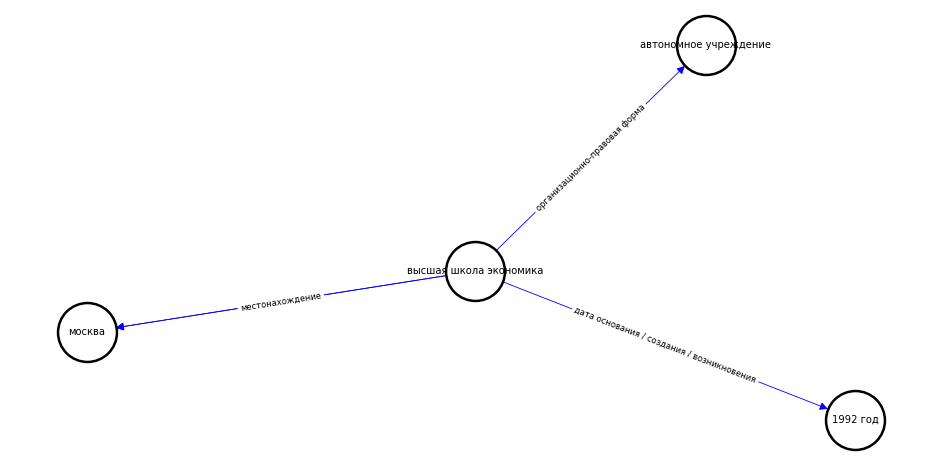

In [130]:
draw_kg(df_pairs)

In [131]:
df_pairs.to_csv('hse-relations.xlsx')